<a href="https://colab.research.google.com/github/AbdurNawaz/Mountain-car-Continous/blob/master/MountainCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gym
import time
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print(env.observation_space)
print(env.action_space)
print(env.observation_space.shape)
print(env.action_space.shape)

Box(2,)
Box(1,)
(2,)
(1,)


In [0]:
class Agent(nn.Module):

  def __init__(self, env, h_size=16):
    super(Agent, self).__init__()
    self.env = env

    self.s_size = env.observation_space.shape[0]
    self.h_size = h_size
    self.a_size = env.action_space.shape[0]

    self.fc1 = nn.Linear(self.s_size, self.h_size)
    self.fc2 = nn.Linear(self.h_size, self.a_size)
  
  def set_weights(self, weights):
    s_size = self.s_size
    h_size = self.h_size
    a_size = self.a_size

    fc1_end = (s_size*h_size) + h_size
    fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
    fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
    fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
    fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])

    self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
    self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
    self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
    self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))

  def get_weights_dim(self):
    return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.tanh(self.fc2(x))
    return x.cpu().data

  def evaluate(self, weights, gamma=1.0, max_t=5000):
    self.set_weights(weights)
    episode_return = 0.0
    state = self.env.reset()
    for t in range(max_t):
      state = torch.from_numpy(state).float().to(device)
      action = self.forward(state)
      state, reward, done, info = self.env.step(action)
      episode_return += reward*math.pow(gamma, t)
      if done:
        break
    return episode_return

agent = Agent(env).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -3.13
Episode 20	Average Score: -4.55
Episode 30	Average Score: -4.06
Episode 40	Average Score: -3.89
Episode 50	Average Score: -5.16
Episode 60	Average Score: -4.60
Episode 70	Average Score: -4.19
Episode 80	Average Score: 1.91
Episode 90	Average Score: 12.07
Episode 100	Average Score: 20.31
Episode 110	Average Score: 30.08
Episode 120	Average Score: 40.07
Episode 130	Average Score: 49.86
Episode 140	Average Score: 59.58
Episode 150	Average Score: 70.01
Episode 160	Average Score: 79.57
Episode 170	Average Score: 89.23

Environment solved in 71 iterations! 	Average Sore: 90.17


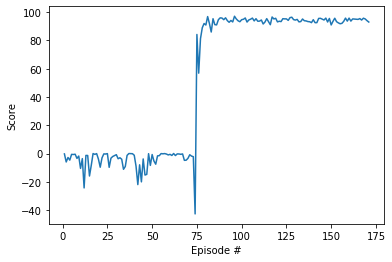

In [38]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):

  n_elite = int(pop_size*elite_frac)

  scores_deque = deque(maxlen=100)
  scores = []
  best_weight = sigma*np.random.randn(agent.get_weights_dim())

  for i_iteration in range(1, n_iterations+1):
    weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
    rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])  

    elite_indxs = rewards.argsort()[-n_elite:]
    elite_weights = [weights_pop[i] for i in elite_indxs]
    best_weight = np.array(elite_weights).mean(axis=0)

    reward = agent.evaluate(best_weight, gamma=1.0)
    scores_deque.append(reward)
    scores.append(reward)

    torch.save(agent.state_dict(), 'checkpoint.pth')

    if i_iteration % print_every == 0:
      print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

    if np.mean(scores_deque) >= 90.0:
      print('\nEnvironment solved in {:d} iterations! \tAverage Sore: {:.2f}'.format((i_iteration-100), np.mean(scores_deque)))
      break
  
  return scores 

scores = cem()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()